In [3]:
import sys
sys.path.insert(1, '../')

from pckgs.import_pckg import *
from pckgs.units import *
# importing FIRAS data
from FIRAS import *

# importing generic constants and functions
from const_func_general import *
# importing distortion specific constants and functions
from cons_func_distortion import *


from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

from pckgs.plot_params import params
import matplotlib
matplotlib.rcParams.update(params)
#plt.rcParams['font.family'] = 'DeJavu Serif'
cols_default = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
# Importing probability


file_name = "../data/data_output/Probability.npz"
if file_name is not None:
    file = np.load(file_name)
# x:   1D array
x_1Dary_P_import = file['x_P_scan_ary']

# -------------------------------------------------------
# mAp: 1D array
mAp_1Dary_P_import = file['mAp_P_scan_ary']

# -------------------------------------------------------
# P/eps^2: 2D array
P_over_eps2_2Dary_import = file['P_over_eps2_scan_2Dary']


zres_2Dary_import=file['zres_scan_2Dary']


# Interpolation: Log10(P/eps^2), Log10(z_res)
# Input: Log10(mAp), x

Reg_trans= 10**(-100)

log10P_over_eps2_interp = interp2d( np.log10(mAp_1Dary_P_import), x_1Dary_P_import, np.log10(P_over_eps2_2Dary_import + Reg_trans) )
log10zres_interp        = interp2d( np.log10(mAp_1Dary_P_import), x_1Dary_P_import, np.log10(zres_2Dary_import + Reg_trans)  )

# P/eps^2 from 2D interpolation
# Input: Log10(mAp), x
def P_over_eps2_interp(mAp, x):
    
    P_over_eps2_interp = 10**log10P_over_eps2_interp( np.log10(mAp), x )
    
    return P_over_eps2_interp

# zres from 2D interpolation
# Input: Log10(mAp), x
# Note! Here, 'zres_interp' only picks the minimal zres when there is multi solution
def zres_interp(mAp,x):
    
    zres_interp = 10**log10zres_interp( np.log10(mAp), x )
    
    return zres_interp



In [5]:
# Delta_I/eps^2 for RAD universe (Approx)
# x :      1D array N_x
# xp:      1D array N_xp  (integration variable)
# output:  1D array N_x

# ----------------------------------------------------------------------
# M-Term Only
# ----------------------------------------------------------------------
def DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):

    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # (M-Term Green's Func)
    # Input x is array:
    # 2D array: N_x * N_xp  
    greens_mu_ary = greens_mu_M(x, x_prime_int, z_res, T0, units=units)
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary  = np.transpose(P_over_eps2_interp(m_Aprime, x_prime_int))[0]

    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_AToAp_over_eps2 = (-1)/(2*zeta(3)) * np.trapz(greens_mu_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_AToAp_over_eps2



# Delta_I/eps^2
# x :      1D array N_x
# xp:      1D array N_xp  (integration variable)
# output:  1D array N_x

# DeltaI/eps^2: Y-part
def DeltaI_over_eps2_Y_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Green's Func at y-era: Y-part
    # 2D array: N_x * N_xp
    greens_Y_ary = greens_Y(x, x_prime_int, z_res, T0, units=units)
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_Y = (-1)/(2*zeta(3)) * np.trapz(greens_Y_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_over_eps2_Y



# Delta_I/eps^2: Doppler-part
def DeltaI_over_eps2_Doppler_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Green's Func at y-era: Y-part
    # 2D array: N_x * N_xp
    greens_Doppler_ary = greens_Doppler(x, x_prime_int, z_res, T0, units=units)
    
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_Doppler = (-1)/(2*zeta(3)) * np.trapz(greens_Doppler_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    return DeltaI_over_eps2_Doppler



# Delta_I/eps^2: Doppler-part (small y_gamma limit)
def DeltaI_over_eps2_Doppler_delta(x, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    if   units == 'eV_per_cmSq': # units:    eV * cm^-2 * sr^-1
        prefac = 1
    elif units == 'SI':          # SI units: kg * s^-2 * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2
    elif units == 'MJy':         # units:    MJy * sr^-1
        prefac = eV_to_J * (1/cm_to_m)**2 * 1e26 / 1e6
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # P(A->Ap)/eps^2
    # 1D array: N_x
    # Analytically, we integrate out delta(x_prime -x)
    P_over_eps2_num = np.transpose(P_over_eps2_interp(m_Aprime, x))[0]
    
    # photon energy density
    rho_gamma = (np.pi**2/15) * T0**4  # in eV^4
    
    # tau_ff
    # 1D array N_xp
    # Note: Here, x_prime = x, because of delta(x_prime-x)
    tau = tau_ff(x, z_res)
    
    # Delta_I(A->Ap): small y_gamma limit
    # int over xp
    # 1D array: N_x
    # unit: eV^3
    DeltaI_over_eps2_Doppler_eV3 = - alpha_rho/(2*zeta(3)) * rho_gamma/(4*np.pi) * (2*np.pi/T0) * np.exp(-tau) * x**3/(np.exp(x)-1) * P_over_eps2_num
    
    DeltaI_over_eps2_Doppler = prefac * DeltaI_over_eps2_Doppler_eV3 * (1/cmInv_to_eV)**2
    
    return DeltaI_over_eps2_Doppler



# Delta_I/eps^2: Doppler-part
# When y_gamma<=10^-3, switch approximate Doppler term with delta function
def DeltaI_over_eps2_Doppler_switch(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Compton y-parameter (photon)
    y = y_gamma(z_res)
    
    # Determine whether do delta-func approximation
    Approx_Det = (y <= 10**(-3))
    
    # If y<<1   (Approx_Det = True ), we use delta func approx for Doppler,
    # Otherwise (Approx_Det = False), we do numerical integral for Doppler
    DeltaI_over_eps2_Doppler  = np.where(Approx_Det
                          ,DeltaI_over_eps2_Doppler_delta(x,m_Aprime,T0,units=units)
                          ,DeltaI_over_eps2_Doppler_int(x,x_prime_int,m_Aprime,T0,units=units))
    
    return DeltaI_over_eps2_Doppler
    

# DeltaI/eps^2 (Total)
# Full Integration
def DeltaI_over_eps2_y_int(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Delta_I(A->Ap)
    # int over xp
    # 1D array: N_x
    DeltaI_over_eps2_y_int = DeltaI_over_eps2_Y_int(x,x_prime_int,m_Aprime,T0,units=units) + DeltaI_over_eps2_Doppler_int(x,x_prime_int,m_Aprime,T0,units=units)
    
    return DeltaI_over_eps2_y_int


# Delta_I/eps^2 (Total): 
# Y-contribution(int) + Doppler-contribution(switch)
def DeltaI_over_eps2_y_switch(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    DeltaI_over_eps2  = DeltaI_over_eps2_Y_int(x,x_prime_int,m_Aprime,T0,units=units) + DeltaI_over_eps2_Doppler_switch(x,x_prime_int,m_Aprime,T0,units=units)

    return DeltaI_over_eps2


# Default values used from 1304.6120v2, z_trans=5.8 * 10**4, Power_trans   = 1.88  

def Ttrans_mu(z, z_trans = 5.8 * 10**4, Power_trans = 1.88):
    
        
    
    Ttrans_mu = 1 - np.exp( -((1+z)/(1+z_trans))**Power_trans )
    
    return Ttrans_mu


# Default values used from 1304.6120v2, z_trans=6e4, Power_trans   = 2.58

def Ttrans_y(z, z_trans = 6e4, Power_trans = 2.58):
    
    Ttrans_y = 1/( 1 + ((1+z)/z_trans)**Power_trans )
    
    return Ttrans_y

#Transition functions from McDermott et al (1911.05086)


def Ttrans_y_rep(z, z_trans = 6e4, Power_trans = 2.58):
    
    Ttrans_y = 1/( 1 + ((1+z)/z_trans)**Power_trans )
    
    return Ttrans_y



def Ttrans_mu_rep(z):
    
        
    Ttrans_mu = 1 - Ttrans_y_rep(z)
    
    return Ttrans_mu




def DeltaI_over_eps2_muy_trans(x, x_prime_int, m_Aprime, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # Check whether in the pure-mu region
    mu_era_Check = (z_res > z_trans_2)

    
    DeltaI_over_eps2_muy_trans =  np.where(mu_era_Check,
                                        DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = units),
                                        ( Ttrans_mu(z_res) * DeltaI_over_eps2_mu_M_int(x, x_prime_int, m_Aprime, T0, units = units) 
                                        + (1-Ttrans_mu(z_res)) * DeltaI_over_eps2_y_switch(x, x_prime_int, m_Aprime, T0, units = units) ) 
                                              )

    return DeltaI_over_eps2_muy_trans






# This is used in chi^2 analysis
def I0_dist_muy_trans(x, x_prime_int, m_Aprime, eps, T0, units = 'eV_per_cmSq'):
    
    # CMB intensity after distortion
    # 1D array: N_x
    I0_dist_y = I0(x, T0, units=units) + eps**2 * DeltaI_over_eps2_muy_trans(x, x_prime_int, m_Aprime, T0, units = units)
    
    return I0_dist_y



# in this function you can pass which type of distortion to be used
#if nothing is passed mu_y_trans distortion with greens functions will be used

def I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy', dist_type='greens' ):
    
    # this is distortion with greens functions
    if dist_type=='greens':
            I0_dist_type=I0_dist_muy_trans( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    # this is free streaming distortion
    if dist_type=='freestreaming':
            I0_dist_type=I0( x_ary, T0_vary, units='MJy' ) * ( 1 - eps**2 * np.transpose( P_over_eps2_interp( m_Aprime, x_ary ) )[0] )    # in MJy/sr

    return I0_dist_type


def chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type='greens'):
    
    # [[[Data]]]
    nu_ary = FIRAS_nu_ary  # in cm^-1
    
    # [[[Data]]]
    x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
    x_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
    # [[[Data]]]
    # I0 from FIRAS measurement
    I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
    # [[[Data]]]
    # Residual of FIRAS
    res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
    # [[[Data]]]
    # Uncertainty of FIRAS
    sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
    # I0 after distortion
    I0_dist_ary = I0_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, 'MJy', dist_type)

    # Difference between data and theory
    diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
    # chi^2
    # Here 10^6 change kJy/sr in Cov to MJy/sr
    chi_sq = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6
    
    return chi_sq


# ----------------------------------------------------------------------
# chi^2 with T0 minimization
# ----------------------------------------------------------------------
def chi_sq_minT0( x_prime_int, m_Aprime, eps, dist_type='greens'):
    
    def chi_sq_T0vary(T0_vary):
        
        return chi_sq( x_prime_int, m_Aprime, eps, T0_vary, dist_type )
    
    # full outout of chi^2 minimization over T0
    

    chi_sq_minT0_full_output   = optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)

    
    T0_min_K     = chi_sq_minT0_full_output[0]/K
    
    chi_sq_minT0 = chi_sq_minT0_full_output[1]
    

    return chi_sq_minT0

# ----------------------------------------------------------------------
# chi^2 with epsilon minimization
# ----------------------------------------------------------------------

def chi_sq_minT0_mineps( x_prime_int, m_Aprime, dist_type='greens'):
    
    def chi_sq_minT0_log10epsvary( log10eps ):
        
        return chi_sq_minT0( x_prime_int, m_Aprime, 10**log10eps, dist_type )

    chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
   
    
    eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
    chi_sq_minT0_mineps = chi_sq_minT0_minlog10eps_full_output[1]
    
    return chi_sq_minT0_mineps



In [6]:


# Exact calculation of mu from thermal energy injection
def mu_th(x_prime_int, m_Aprime, eps):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    mu_th = (3/kappa_c) * J_bb(z_res) * (15/np.pi**4) * eps**2 * np.trapz( x_prime_int**3/(np.exp(x_prime_int) -1) * P_over_eps2_ary, x_prime_int)
    
    return mu_th


# Exact calculation of y from thermal energy injection
def y_th(x_prime_int, m_Aprime, eps):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose( P_over_eps2_interp(m_Aprime, x_prime_int) )[0]
    
    y_th = (1/4) * (15/np.pi**4) * eps**2 * np.trapz( x_prime_int**3/(np.exp(x_prime_int) -1) * P_over_eps2_ary, x_prime_int)
    
    return y_th


# I0_dist (only mu)
def I0_mu_dist(x, x_prime_int, m_Aprime, eps, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # CMB intensity after distortion
    # 1D array: N_x
    # I0_mu_dist = I0(x, T0, units=units) + Ttrans_mu(z_res) * mu_th(x_prime_int, m_Aprime, eps) * M(x, T0, units=units)
    I0_mu_dist = I0(x, T0, units=units) - Ttrans_mu(z_res) * mu_th(x_prime_int, m_Aprime, eps) * M(x, T0, units=units)
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    return I0_mu_dist

# I0_dist (only y)
def I0_y_dist(x, x_prime_int, m_Aprime, eps, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # CMB intensity after distortion
    # 1D array: N_x
    I0_y_dist = I0(x, T0, units=units) - Ttrans_y(z_res) * y_th(x_prime_int, m_Aprime, eps) * Y(x, T0, units=units)
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    return I0_y_dist

# I0_dist (mu-y transition)
def I0_trans_dist(x, x_prime_int, m_Aprime, eps, T0, units = 'eV_per_cmSq'):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    # CMB intensity after distortion
    # 1D array: N_x
    I0_trans_dist = I0(x, T0, units=units) - Ttrans_mu(z_res) * mu_th(x_prime_int, m_Aprime, eps) * M(x, T0, units=units) - Ttrans_y(z_res) * y_th(x_prime_int, m_Aprime, eps) * Y(x, T0, units=units)
    # @@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
    
    return I0_trans_dist

In [7]:
# Exact calculation of mu from photon injection
def mu_photon(x_prime_int, m_Aprime, eps):
    
    x_input  = np.array([3])
    T0_input = TCMB_0
    
    mu_photon_ary = - eps**2 * DeltaI_over_eps2_mu_M_int(x_input, x_prime_int, m_Aprime, T0_input, units = 'MJy')/M(x_input, T0_input, units='MJy')
    
    mu_photon = mu_photon_ary[0]
    
    return mu_photon


# Exact calculation of mu from photon injection (Direct Calc)
def mu_photon_2(x_prime_int, m_Aprime, eps):
    
    # Here we choose x_prime = 0
    z_res = zres_interp(m_Aprime, 0)[0]
    
    # 1D array  N_xp
    greens_mu_over_M_ary = (   3 * alpha_rho / kappa_c
        * (x_prime_int - x_0 * survival_prob(x_prime_int, z_res))
        * J_bb(z_res) )
    
    # P(A->Ap)/eps^2
    # 1D array: N_xp
    P_over_eps2_ary = np.transpose(P_over_eps2_interp(m_Aprime, x_prime_int))[0]
    
    # mu_th
    # int over xp
    # 1D array: N_x
    mu_th_over_eps2 = (-1) * (-1)/(2*zeta(3)) * np.trapz(greens_mu_over_M_ary *  x_prime_int**2/(np.exp(x_prime_int)-1) * P_over_eps2_ary, x_prime_int)
    
    mu_th = mu_th_over_eps2 * eps**2
    
    return mu_th
    
    

In [8]:
# ----------------------------------------------------------------------
# chi^2 without T0 minimization
# ----------------------------------------------------------------------
# (Note: x_prime_int denotes the integration variable x_prime)

def chi_sq( x_prime_int, m_Aprime, eps, T0_vary, era='mu' ):
    
    # [[[Data]]]
    nu_ary = FIRAS_nu_ary  # in cm^-1
    
    # [[[Data]]]
    x_data_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/TCMB_0
    
    # <<<Use T0_vary>>>
    x_ary  = 2 * np.pi * nu_ary * cmInv_to_eV/T0_vary
    
    # [[[Data]]]
    # I0 from FIRAS measurement
    I0_data_ary = I0( x_data_ary, TCMB_0, units='MJy' )    # in MJy/sr
    
    # [[[Data]]]
    # Residual of FIRAS
    res_data_ary   = FIRAS_res_ary * 10**(-3)         # in MJy/sr
    
    # [[[Data]]]
    # Uncertainty of FIRAS
    sigma_data_ary = FIRAS_sigma_ary * 10**(-3)       # in MJy/sr
    
    # <<<Use T0_vary>>>
    # I0 after distortion
    if era=='mu':
        I0_dist_ary = I0_mu_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    if era=='trans':
        I0_dist_ary = I0_trans_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    if era=='y':
        I0_dist_ary = I0_y_dist( x_ary, x_prime_int, m_Aprime, eps, T0_vary, units = 'MJy')    # in MJy/sr
    
    # Difference between data and theory
    diff_I0_ary = I0_data_ary + res_data_ary - I0_dist_ary
    
    # chi^2
    # Here 10^6 change kJy/sr in Cov to MJy/sr
    chi_sq = np.linalg.multi_dot([diff_I0_ary, Cov_Inv, diff_I0_ary]) * 10**6
    
    return chi_sq

# ----------------------------------------------------------------------
# chi^2 with T0 minimization
# ----------------------------------------------------------------------
def chi_sq_minT0( x_prime_int, m_Aprime, eps, era='mu' ):
    
    def chi_sq_T0vary(T0_vary):
        
        return chi_sq( x_prime_int, m_Aprime, eps, T0_vary, era )
    
    # full outout of chi^2 minimization over T0
    chi_sq_minT0_full_output   = optimize.fmin(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)
    # chi_sq_minT0_full_output = optimize.fmin_powell(chi_sq_T0vary, np.array([TCMB_0]), full_output=True, disp=False)
    # chi_sq_minT0_full_output = optimize.brent(chi_sq_T0vary, brack=(2.6*K, 2.9*K), full_output=True)
    
    T0_min_K     = chi_sq_minT0_full_output[0]/K
    
    chi_sq_minT0 = chi_sq_minT0_full_output[1]
    
    return chi_sq_minT0

# ----------------------------------------------------------------------
# chi^2 with epsilon minimization
# ----------------------------------------------------------------------

def chi_sq_minT0_mineps( x_prime_int, m_Aprime , era='mu'):
    
    def chi_sq_minT0_log10epsvary( log10eps ):
        
        return chi_sq_minT0( x_prime_int, m_Aprime, 10**log10eps, era)

    chi_sq_minT0_minlog10eps_full_output =  optimize.fmin(chi_sq_minT0_log10epsvary, np.array([-10]), full_output=True, disp=False)
    # chi_sq_minT0_minlog10eps_full_output = optimize.brent( chi_sq_minT0_log10epsvary, brack=(-10, 0), full_output=True )
    
    eps_min = 10**chi_sq_minT0_minlog10eps_full_output[0]
    
    chi_sq_minT0_mineps = chi_sq_minT0_minlog10eps_full_output[1]
    
    return chi_sq_minT0_mineps


In [7]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below


# mu era calculation

# x_prime_int_test = np.logspace(-4,2,1000)
# x_prime_int_test = np.logspace(-1,2,1000)
x_prime_int_test = np.logspace(-3,5,200)

m_Ap_min = 10**(-9)  # in eV
m_Ap_max = 10**(-3)  # in eV

eps_min = 10**(-8)
eps_max = 10**(-3)

N_m_Ap = 50
N_eps  = 70

m_Ap_ary = np.logspace( np.log10(m_Ap_min), np.log10(m_Ap_max), N_m_Ap )
eps_ary  = np.logspace( np.log10(eps_min) , np.log10(eps_max) , N_eps  )


# 2D array: N_eps * N_mAp
TS_2Dary = np.zeros((len(eps_ary),len(m_Ap_ary)))

era_curr='mu' 

# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
    
    m_Ap_j   =  m_Ap_ary[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j, era_curr )
    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        
        eps_i   =  eps_ary[i]
        
        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i, era_curr ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        



In [14]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below

# Exporting Probability and mAp and x_p values
np.savez("../data/data_output/muFIRAS_PureEnergyInj.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [15]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below

# y era calculattion

m_Ap_ary = np.logspace( np.log10(m_Ap_min), np.log10(m_Ap_max), N_m_Ap )
eps_ary  = np.logspace( np.log10(eps_min) , np.log10(eps_max) , N_eps  )


# 2D array: N_eps * N_mAp
TS_2Dary = np.zeros((len(eps_ary),len(m_Ap_ary)))

era_curr='y' 

# TS_ij: (eps_i, mAp_j)
# j: The number of column

# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
    
    m_Ap_j   =  m_Ap_ary[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j, era_curr )
    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        
        eps_i   =  eps_ary[i]
        
        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i, era_curr ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        


In [16]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below

# Exporting Probability and mAp and x_p values
np.savez("../data/data_output/yFIRAS_PureEnergyInj.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [17]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below

# mu-y transition era calculation
m_Ap_ary = np.logspace( np.log10(m_Ap_min), np.log10(m_Ap_max), N_m_Ap )
eps_ary  = np.logspace( np.log10(eps_min) , np.log10(eps_max) , N_eps  )


# 2D array: N_eps * N_mAp
TS_2Dary = np.zeros((len(eps_ary),len(m_Ap_ary)))

era_curr='trans' 

# TS_ij: (eps_i, mAp_j)
# j: The number of column

# TS_ij: (eps_i, mAp_j)
# j: The number of column
for j in tqdm_notebook(range(0, len(m_Ap_ary))):
    
    m_Ap_j   =  m_Ap_ary[j]
    
    chi_sq_minT0_mineps_value = chi_sq_minT0_mineps( x_prime_int_test, m_Ap_j, era_curr )
    
    
    # i: The number of row
    for i in range(0, len(eps_ary)):
        
        eps_i   =  eps_ary[i]
        
        TS = chi_sq_minT0( x_prime_int_test, m_Ap_j, eps_i, era_curr ) - chi_sq_minT0_mineps_value
        
        TS_2Dary[i][j] = TS
        



In [18]:
#unless calculattions are being redone, one can skip this and move to importing, 
#it will import already calculated data below

# Exporting Probability and mAp and x_p values
np.savez("../data/data_output/transFIRAS_PureEnergyInj.npz",
         m_Ap_ary=m_Ap_ary,
         eps_ary=eps_ary,
         TS_2Dary=TS_2Dary
         )


In [9]:
#importing files
#run this to import already saved arrays
file_name = "../data/data_output/muFIRAS_PureEnergyInj.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
mu_mAp_1Dary_import= file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
mu_eps_1Dary_import = file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
mu_TS_2Dary_import = file['TS_2Dary']


#importing files
#run this to import already saved arrays
file_name = "../data/data_output/yFIRAS_PureEnergyInj.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
y_mAp_1Dary_import= file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
y_eps_1Dary_import= file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
y_TS_2Dary_import= file['TS_2Dary']



#importing files
#run this to import already saved arrays
file_name = "../data/data_output/transFIRAS_PureEnergyInj.npz"
#file_name = "../data/transFIRAS_5p8e4_1p88.npz"
if file_name is not None:
    file = np.load(file_name)
# mAp:   1D array
trans_mAp_1Dary_import= file['m_Ap_ary']
# -------------------------------------------------------
# eps: 1D array
trans_eps_1Dary_import = file['eps_ary']

# -------------------------------------------------------
# TS: 2D array
trans_TS_2Dary_import = file['TS_2Dary']


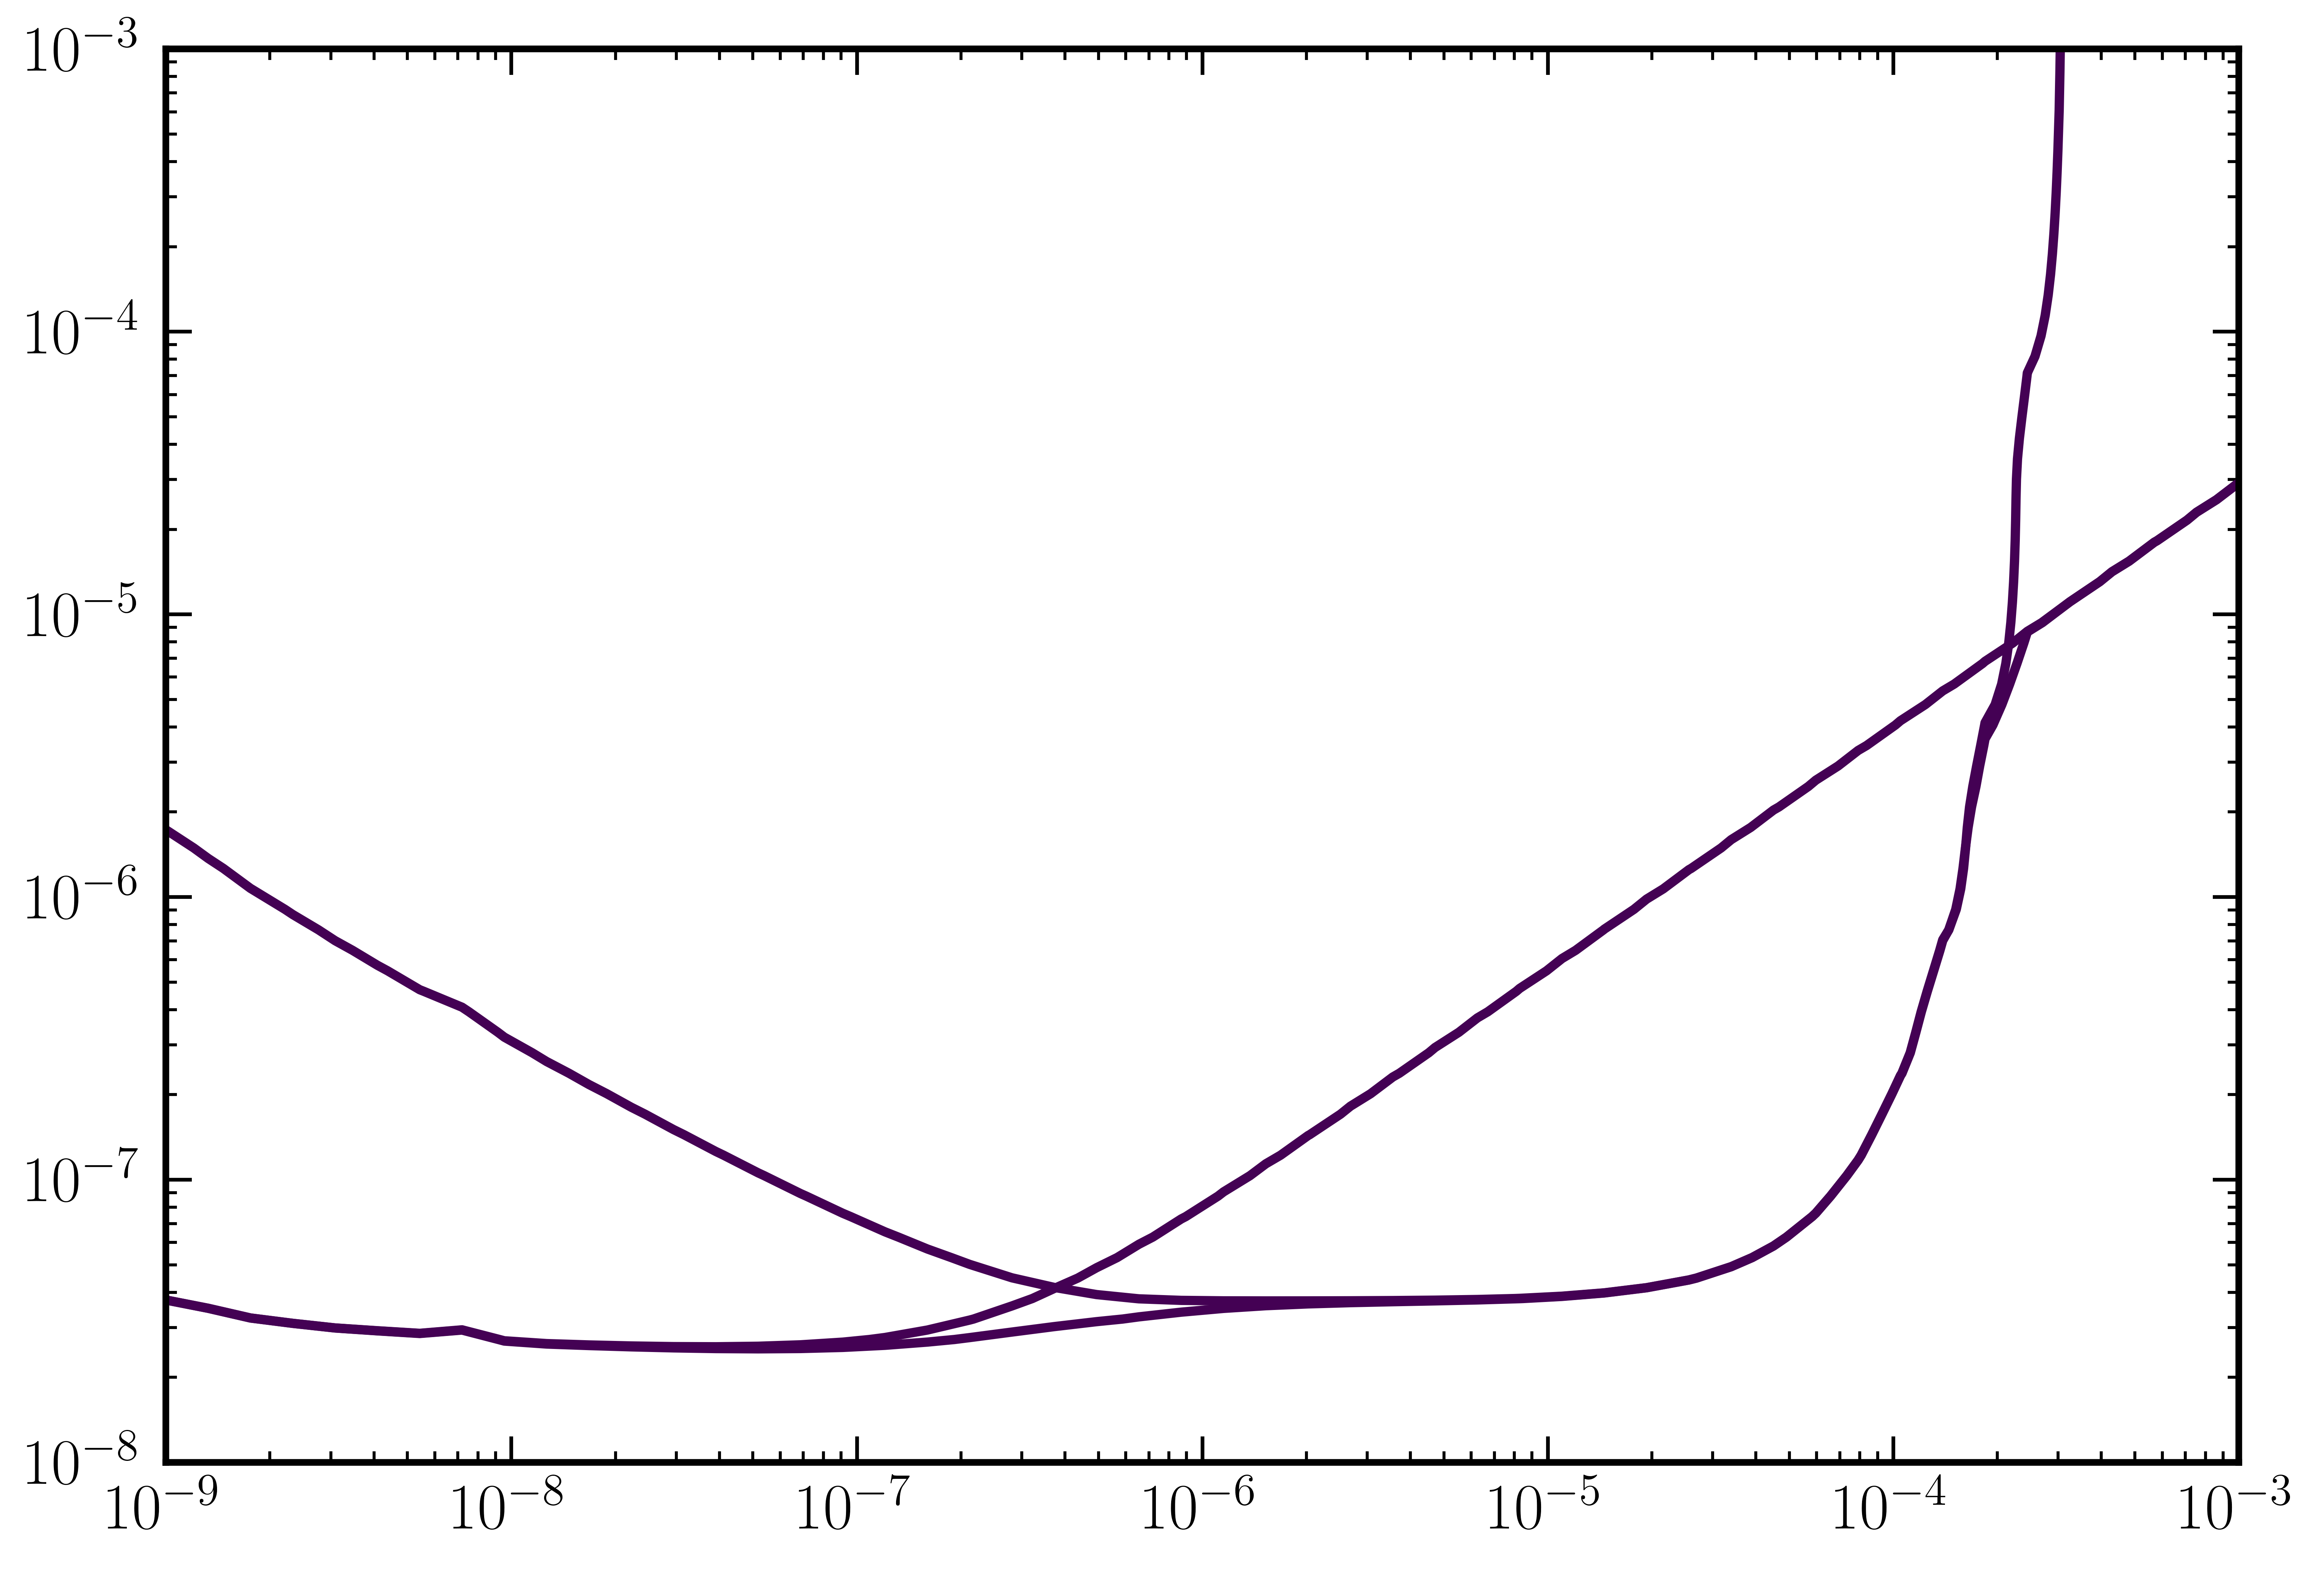

In [10]:

mu_abs_FIRAS_1 = 6*10**(-5)  # From  McDermott et al (1911.05086) 
mu_abs_FIRAS_2 = 9*10**(-5)  # From COBE-FIRAS's astro-ph/9605054

y_abs_FIRAS  = 15 * 10**(-6) # From COBE-FIRAS's astro-ph/9605054

x_prime_int_test = np.logspace(-3,3,1000)

mAp_list_test = np.logspace(-10,-3,300)

z_res_list_test = [ zres_interp(mAp, 0)[0] for mAp in mAp_list_test ]

Ttrans_mu_list_test = [ Ttrans_mu(z_res) for z_res in z_res_list_test ]
Ttrans_y_list_test  = [ Ttrans_y(z_res) for z_res in z_res_list_test ]


eps_test = 1

eps_list_mu_value_FIRAS_1 = [ np.sqrt( mu_abs_FIRAS_1/( Ttrans_mu_rep(zres_interp(mAp_test, 0)[0]) * np.abs(mu_th(x_prime_int_test, mAp_test, eps_test)) ) ) for mAp_test in mAp_list_test ]
eps_list_mu_value_FIRAS_2 = [ np.sqrt( mu_abs_FIRAS_2/( Ttrans_mu_rep(zres_interp(mAp_test, 0)[0]) * np.abs(mu_th(x_prime_int_test, mAp_test, eps_test)) ) ) for mAp_test in mAp_list_test ]

eps_list_y_value_FIRAS_1 = [ np.sqrt( y_abs_FIRAS/( Ttrans_y_rep(zres_interp(mAp_test, 0)[0]) * np.abs(y_th(x_prime_int_test, mAp_test, eps_test)) ) ) for mAp_test in mAp_list_test ]


# Boundary of mu-y transition era
z_trans_1   = 10**4
z_trans_2   = 3 * 10**5
z_dcs       = 2 * 10**6  # Redshift of double Compton scattering

mAp_trans_1 = np.sqrt( mAsq(z_trans_1, 0) ) # in eV
mAp_trans_2 = np.sqrt( mAsq(z_trans_2, 0) ) # in eV
mAp_dcs     = np.sqrt( mAsq(z_dcs, 0) ) # in eV

# Delta 95%CL, From PDG Statistics
# TS_choose = 5.99
TS_choose = 2.71

TS_Reg = 0.1

import matplotlib.cm as cm


# --------------------------------------------------------------------------------
X_mu_plt, Y_mu_plt  = np.meshgrid( mu_mAp_1Dary_import, mu_eps_1Dary_import )
Z_mu_plt            = np.log10(    mu_TS_2Dary_import + TS_Reg )
# --------------------------------------------------------------------------------
X_trans_plt, Y_trans_plt = np.meshgrid( trans_mAp_1Dary_import, trans_eps_1Dary_import )
Z_trans_plt              = np.log10(    trans_TS_2Dary_import + TS_Reg )
# --------------------------------------------------------------------------------
X_y_plt, Y_y_plt = np.meshgrid( y_mAp_1Dary_import, y_eps_1Dary_import )
Z_y_plt              = np.log10( y_TS_2Dary_import + TS_Reg )
# --------------------------------------------------------------------------------


set_matplotlib_formats('retina')
plt.figure(figsize=(10,7))


plt.xscale('log')
plt.yscale('log')

CS_mu     =  plt.contour( X_mu_plt    , Y_mu_plt    , Z_mu_plt    ,  levels = [ np.log10(TS_choose) ])
CS_trans  =  plt.contour(  X_trans_plt , Y_trans_plt , Z_trans_plt ,  levels = [ np.log10(TS_choose) ])
CS_y      =  plt.contour(  X_y_plt     , Y_y_plt     , Z_y_plt     ,  levels = [ np.log10(TS_choose) ])


Greens_PureEnergyInj_mu       = np.transpose(CS_mu.collections[0].get_paths()[0].vertices )
Greens_PureEnergyInj_y = np.transpose(CS_y.collections[0].get_paths()[0].vertices )
Greens_PureEnergyInj_trans    = np.transpose(CS_trans.collections[0].get_paths()[0].vertices )



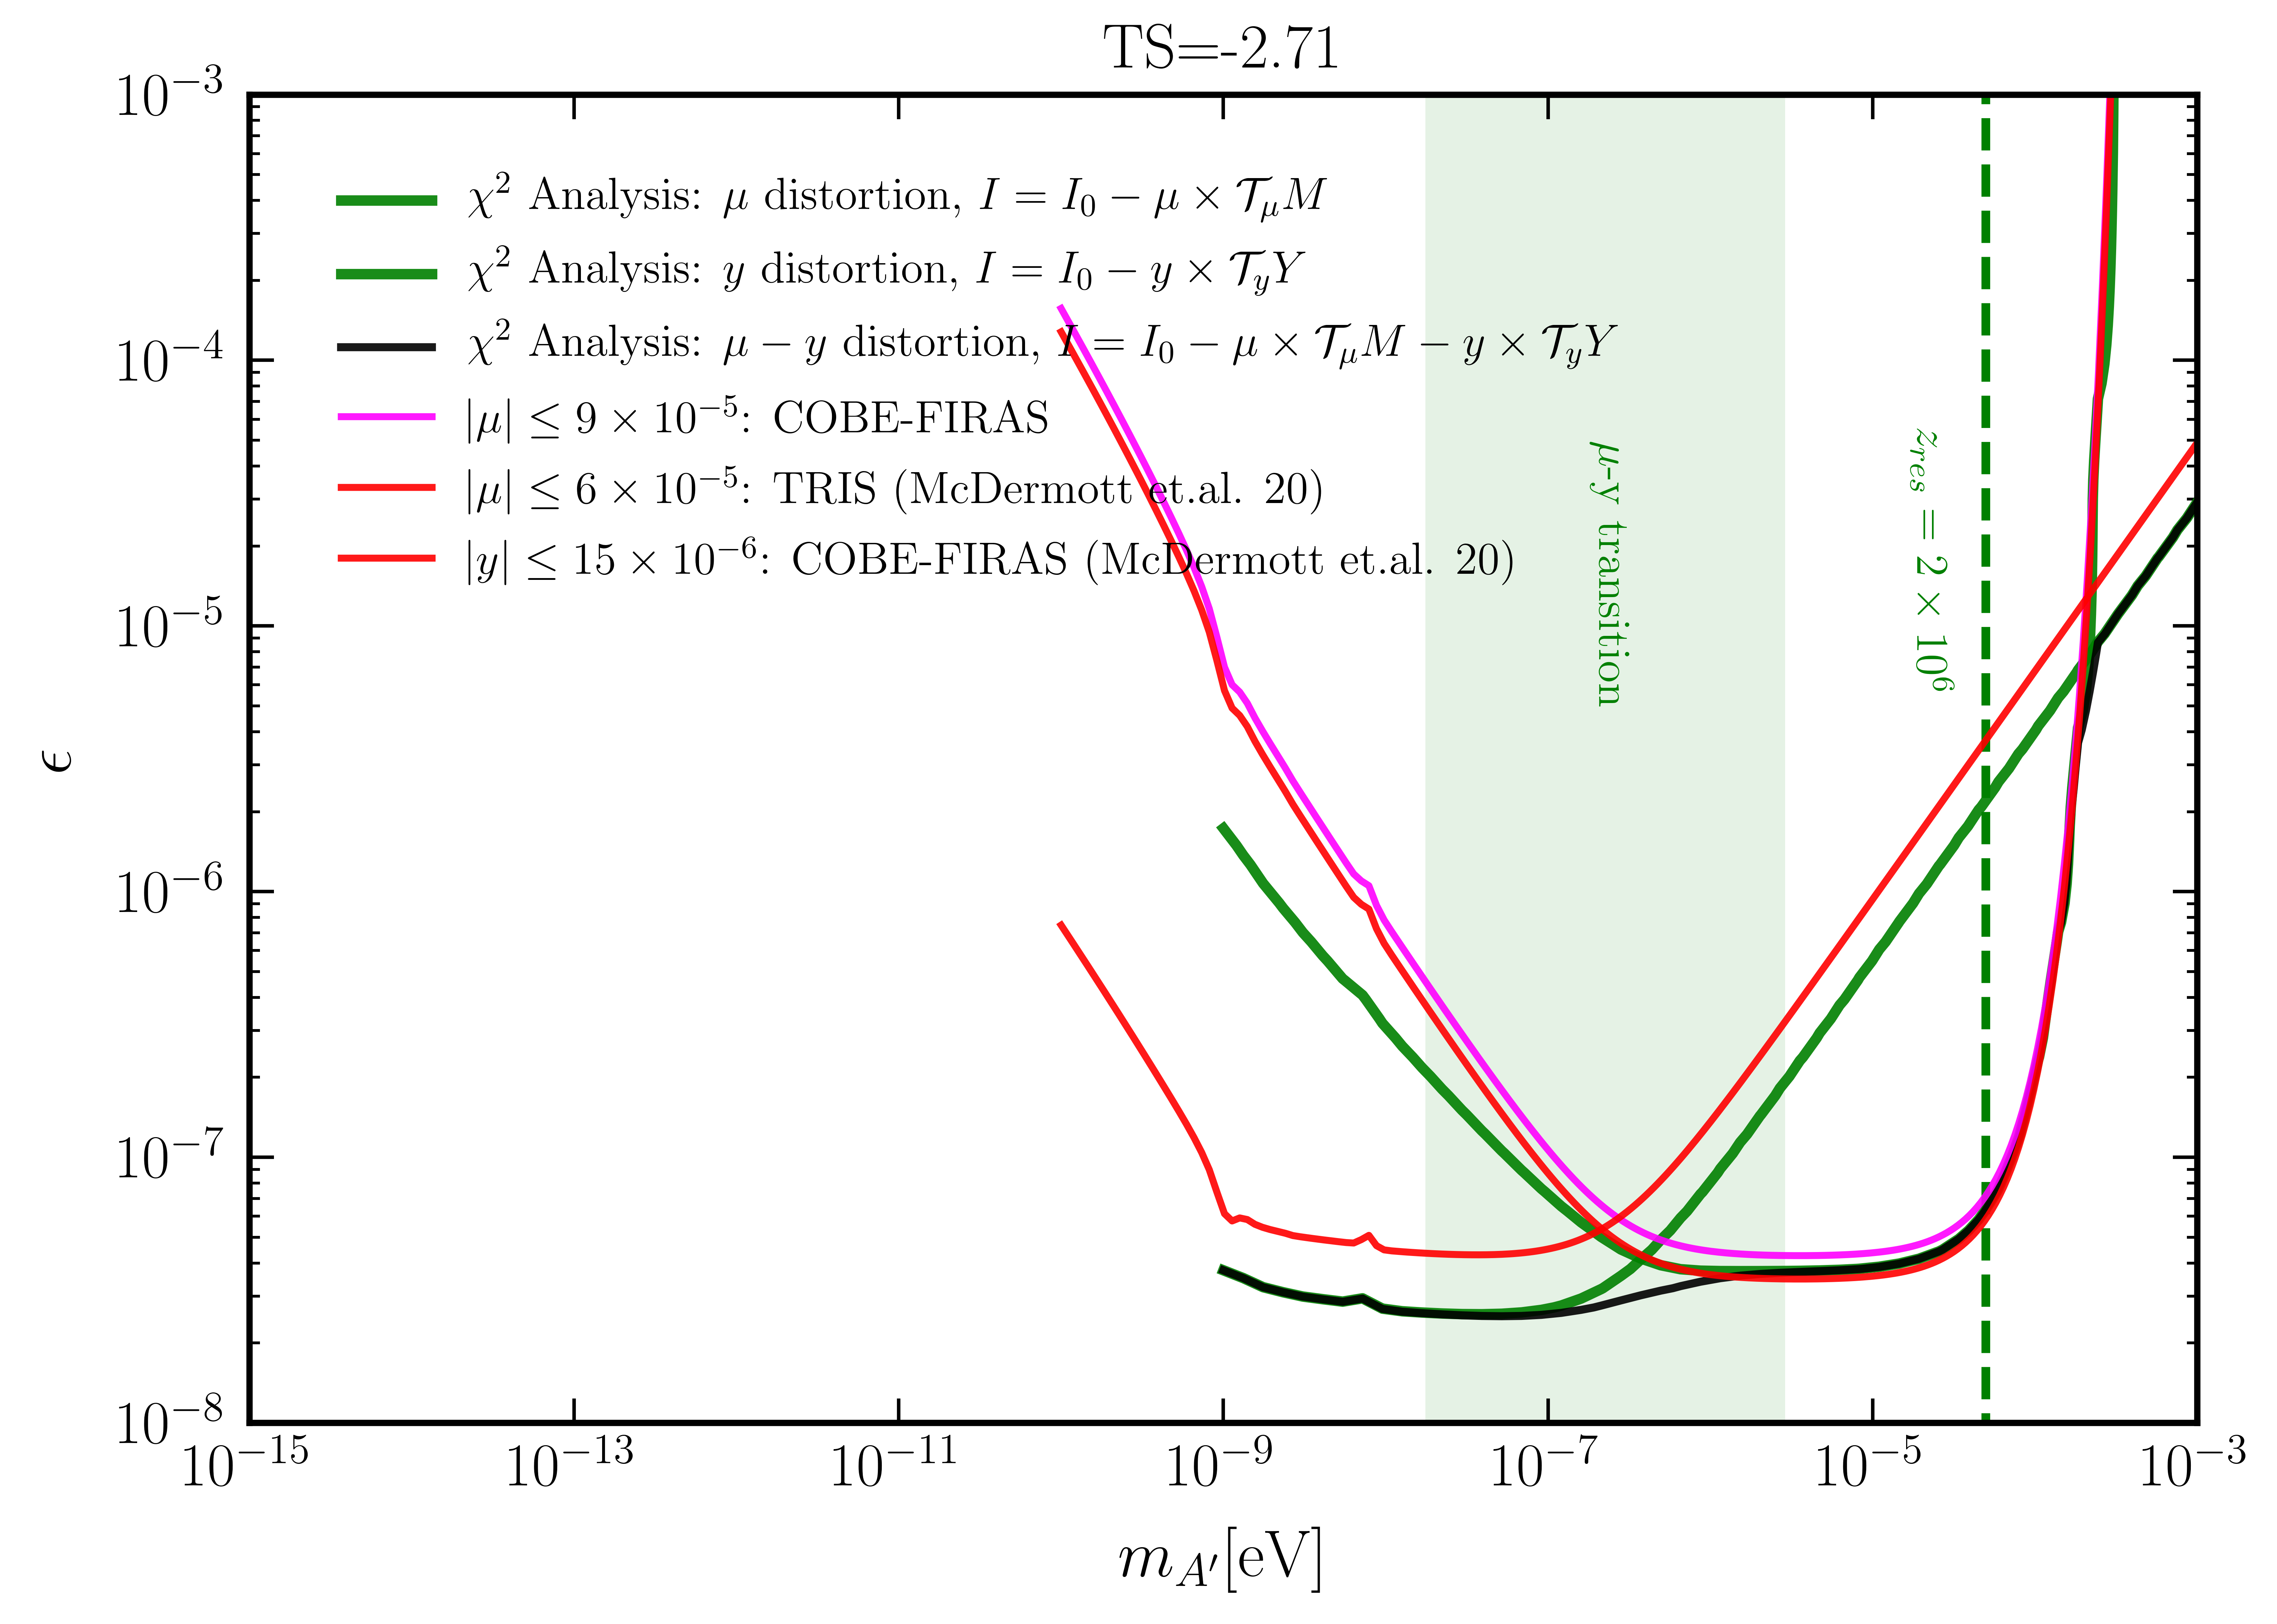

In [11]:


set_matplotlib_formats('retina')
plt.figure(figsize=(10,7))


plt.xscale('log')
plt.yscale('log')

plt.plot( Greens_PureEnergyInj_mu[0]    , Greens_PureEnergyInj_mu[1]    , label = r'$\chi^2$ Analysis: $\mu$ distortion, $I = I_0 - \mu \times \mathcal{T}_\mu M$', color='green',linewidth=3)
plt.plot( Greens_PureEnergyInj_y[0]     , Greens_PureEnergyInj_y[1]     , label = r'$\chi^2$ Analysis: $y$ distortion, $I = I_0 - y \times \mathcal{T}_y Y$', color='green', linewidth=3)
plt.plot( Greens_PureEnergyInj_trans[0] , Greens_PureEnergyInj_trans[1] ,  label = r'$\chi^2$ Analysis: $\mu-y$ distortion, $I = I_0 - \mu \times \mathcal{T}_\mu M - y \times \mathcal{T}_y Y$', color='black',linewidth=2.3)


plt.plot( mAp_list_test , eps_list_mu_value_FIRAS_2, label = r'$|\mu|\leq 9 \times 10^{-5}$: COBE-FIRAS',  color='magenta',linewidth=2.0)
plt.plot( mAp_list_test , eps_list_mu_value_FIRAS_1, label = r'$|\mu|\leq 6 \times 10^{-5}$: TRIS (McDermott et.al. 20)', color='red',linewidth=2.0)
plt.plot( mAp_list_test , eps_list_y_value_FIRAS_1, label = r'$|y|\leq 15 \times 10^{-6}$: COBE-FIRAS (McDermott et.al. 20)',color='red',linewidth=2.0)


#plt.axvspan(mAp_trans_1, mAp_trans_2, alpha=0.1, facecolor='orange', edgecolor=None)

plt.axvspan(mAp_trans_1, mAp_trans_2, alpha=0.1, facecolor='green', edgecolor=None)
plt.vlines(x = mAp_dcs, ymin = 10**(-10), ymax = 1, colors = 'green', label = None, linestyle = 'dashed')

plt.text(1.8e-7 , 5.3e-6 , r'$\mu$-y transition', fontsize=13, color='green', rotation=-90)
plt.text(1.5e-5 , 6e-6   , r'$z_{res}=2\times 10^6$', fontsize=13, color='green', rotation=-90)


# plt.text(1.5e-7, 1e-6, r'$\mu$-y transition', fontsize=15, color='orange', rotation=-90)

plt.title(r'TS=-2.71')

plt.xlim(1e-15, 1e-3)
plt.ylim(1e-8, 1e-3)

plt.xlabel(r'$m_{A^\prime}$[eV]')
plt.ylabel(r'$\epsilon$')

plt.legend(bbox_to_anchor=(0.72, 0.6),fontsize=13.0)
# plt.show()

#plt.savefig('../plots/FIRAS_Bound_PureEnergyInj_Tot.pdf')

In [12]:
#build constraint array and save

mAp_x_1=mAp_list_test
eps_y_1=eps_list_mu_value_FIRAS_1
mAp_x_2=mAp_list_test
eps_y_2=eps_list_y_value_FIRAS_1


N_mAp_list=300
mAp_list_test = np.logspace(np.log10(min(mAp_x_1[0],mAp_x_2[0])),np.log10(min(mAp_x_1[len(mAp_x_1)-1],mAp_x_2[len(mAp_x_2)-1])),N_mAp_list)


eps_interp1=interp1d(mAp_x_1, eps_y_1, kind='linear')(mAp_list_test)
eps_interp2=interp1d(mAp_x_2, eps_y_2, kind='linear')(mAp_list_test)
eps_constraint=np.zeros(len(mAp_list_test))

for i in range(0, len(mAp_list_test)):
                        
    eps_constraint[i]=min(eps_interp1[i],eps_interp2[i])
                        


# Create a sample dataframe
df_pure_energy_injection = pd.DataFrame(np.transpose([np.transpose(mAp_list_test),np.transpose(eps_constraint)]))

# Save the dataframe to a CSV file
df_pure_energy_injection.to_csv('../data/data_output/pure_energy_injection.csv', index=False)


pure_energy_injection = np.transpose( np.array( pd.read_csv('../data/data_output/pure_energy_injection.csv') ) )


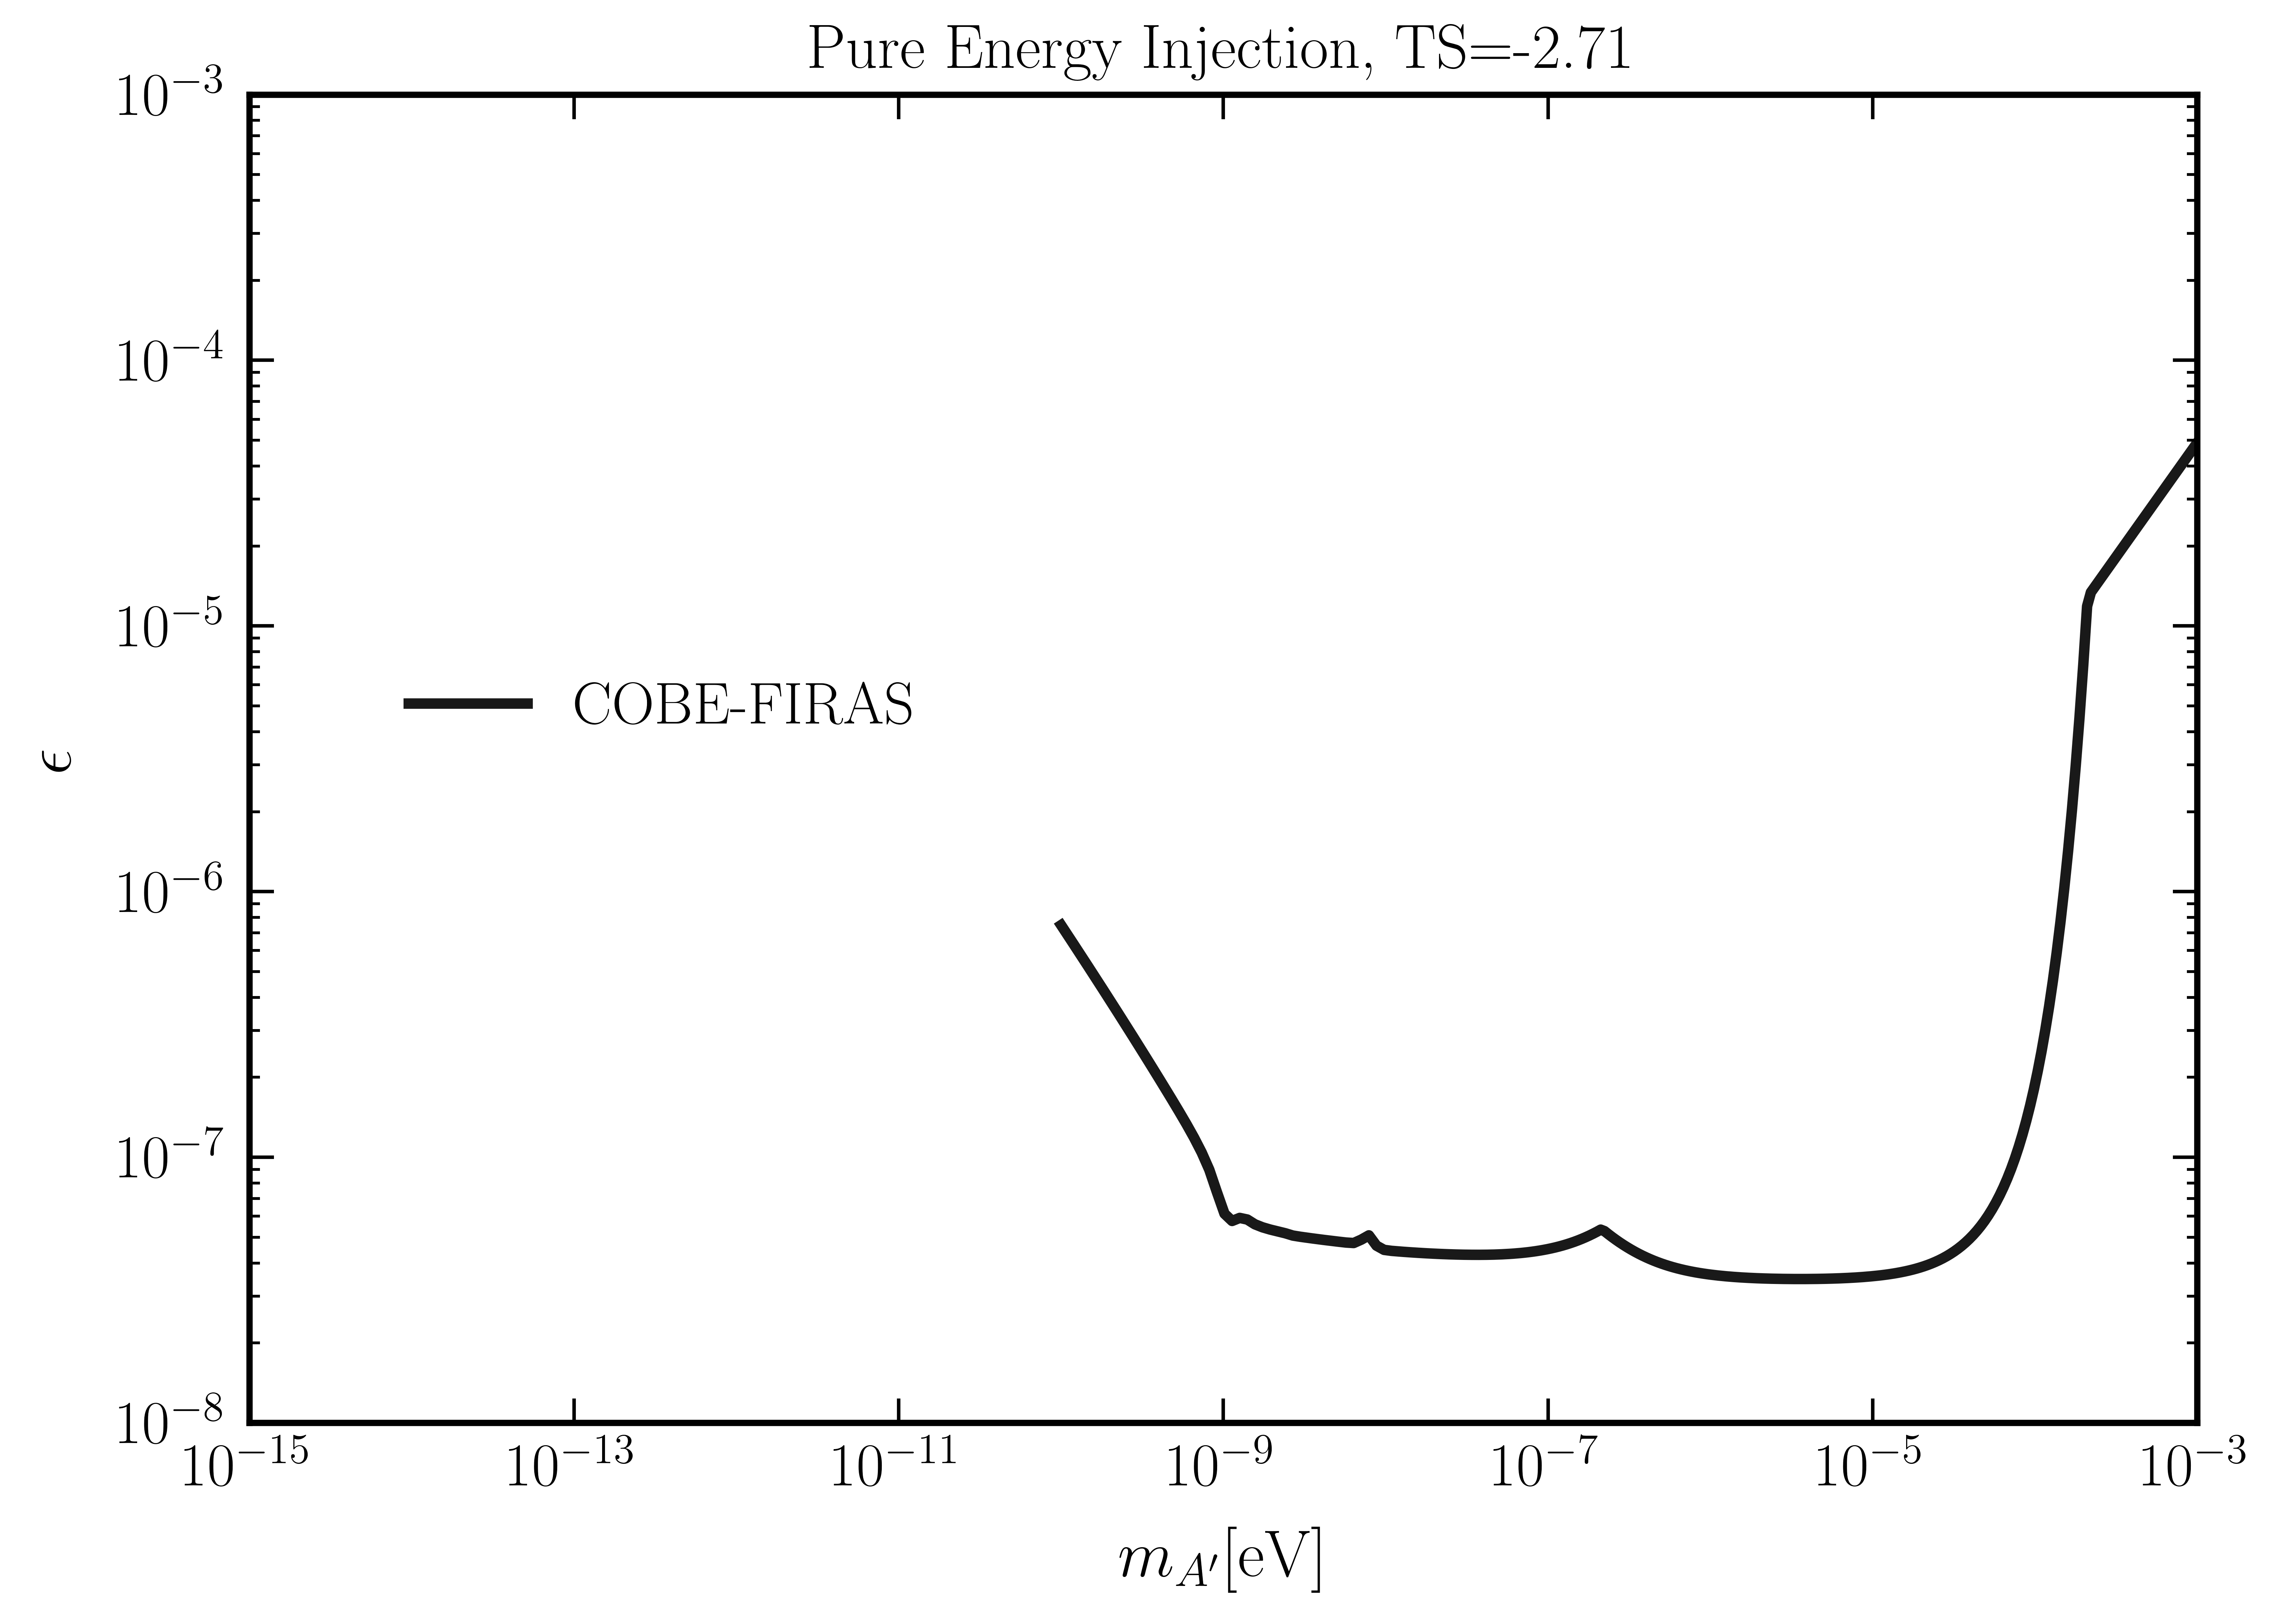

In [13]:


set_matplotlib_formats('retina')
plt.figure(figsize=(10,7))


plt.xscale('log')
plt.yscale('log')

plt.plot(pure_energy_injection[0]   , pure_energy_injection[1]    , label = r'COBE-FIRAS', color='black',linewidth=3)


plt.title(r'Pure Energy Injection, TS=-2.71')

plt.xlim(1e-15, 1e-3)
plt.ylim(1e-8, 1e-3)

plt.xlabel(r'$m_{A^\prime}$[eV]')
plt.ylabel(r'$\epsilon$')

plt.legend(bbox_to_anchor=(0.37, 0.6))
# plt.show()

#plt.savefig('FIRAS_Bound_PureEnergyInj_Tot.pdf')
                        
           
